In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/home/zcapjru/PhD/DEScls/xcell/mappers')


from mapper_base import MapperBase
from astropy.io import fits
from astropy.table import Table

import mapper_DESY1wl
import pyccl as ccl
import numpy as np
import pylab as plt
import pymaster as nmt
import healpy as hp
import os

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
# Initialize binning scheme with 20 ells per bandpower
nside = 256
ells = []
i = 11.5
while i <= 3 * nside:
    ells.append(round(i))
    #i = i*(1+i/(3 * nside))
    i = i+20*(1+i/240)

bands = nmt.NmtBin.from_edges(ells[:-1], ells[1:])
ell_arr = bands.get_effective_ells()

In [3]:
path_data = '/home/zcapjru/PhD/Data/DESwl/'
path_lite = '/home/zcapjru/PhD/Data/DESwl_lite/'
#path_lite = '/home/zcapjru/PhD/Data/David_DESwl_lite/'

In [4]:
fcat_bin = 'catalog_metacal_bin{}_zbin_mcal.fits'.format(0)
os.path.isfile(path_lite + fcat_bin)

False

In [5]:
DESwl_1_config = {'zbin_cat': path_data + 'y1_source_redshift_binning_v1.fits',
        'data_cat':  path_data + 'mcal-y1a1-combined-riz-unblind-v4-matched.fits',
         'file_nz': path_data + 'y1_redshift_distributions_v1.fits',
         'path_lite': path_lite,
         'nside': nside,
         'bin': 0,
         'mask_name': 'name'}


DESwl_2_config = {'zbin_cat': path_data + 'y1_source_redshift_binning_v1.fits',
        'data_cat':  path_data + 'mcal-y1a1-combined-riz-unblind-v4-matched.fits',
         'file_nz': path_data + 'y1_redshift_distributions_v1.fits',
         'path_lite': path_lite ,
         'nside': nside,
         'bin': 1,
         'mask_name': 'name'}


In [6]:
DES_1_maps = mapper_DESY1wl.MapperDESY1wl(DESwl_1_config)
DES_2_maps = mapper_DESY1wl.MapperDESY1wl(DESwl_2_config)

Loading lite bin0 cat
Loading lite bin1 cat


In [7]:
fcat_lite = 'DESwlMETACAL_catalog_lite'
fcat_bin = '{}_zbin{}.fits'.format(fcat_lite, 3)

In [8]:
DES_nz_1 = DES_1_maps.nz
DES_z_1 = DES_nz_1['Z_MID']
DES_dNdz_1 = DES_nz_1['BIN1']

DES_nz_2 = DES_2_maps.nz
DES_z_2 = DES_nz_2['Z_MID']
DES_dNdz_2 = DES_nz_2['BIN2']

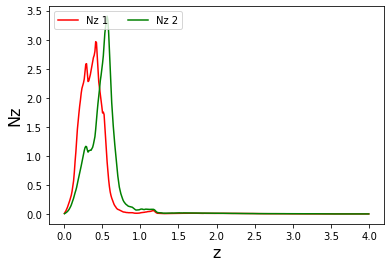

In [9]:
plt.plot(DES_z_1, DES_dNdz_1, 'r-', label='Nz 1')
plt.plot(DES_z_2, DES_dNdz_2, 'g-', label='Nz 2')

plt.xlabel('z', fontsize=16)
plt.ylabel('Nz', fontsize=16)
plt.legend(loc='upper left', ncol=2, labelspacing=0.1)
plt.show()

In [10]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
ia = np.ones(len(DES_z_1))*0.981

DESwl_theory_1 = ccl.WeakLensingTracer(cosmo,  dndz=(DES_z_1,DES_dNdz_1), has_shear=True, ia_bias=(DES_z_1,ia), use_A_ia=True)
Theory_cl_s1s1 = ccl.angular_cl(cosmo, DESwl_theory_1, DESwl_theory_1, ell_arr) 

DESwl_theory_2 = ccl.WeakLensingTracer(cosmo,  dndz=(DES_z_2,DES_dNdz_2), has_shear=True, ia_bias=(DES_z_2,ia), use_A_ia=True)
Theory_cl_s2s2 = ccl.angular_cl(cosmo, DESwl_theory_2, DESwl_theory_2, ell_arr) 

Theory_cl_s1s2 = ccl.angular_cl(cosmo, DESwl_theory_1, DESwl_theory_2, ell_arr)

In [11]:
# Read healpix maps and initialize a spin-0 and spin-2 field
DES_mask_1  = DES_1_maps.get_mask()
DES_signal_1 = DES_1_maps.get_signal_map()
DES_mask_2  = DES_2_maps.get_mask()
DES_signal_2 = DES_2_maps.get_signal_map()

In [12]:
def load_david_cats(zbin):
    output = Table.read('/home/zcapjru/PhD/Data/David_DESwl_lite/catalog_metacal_bin{}_zbin_mcal.fits'.format(zbin))
    return output  

In [13]:
def load_david_maps(mode):
    if mode == 'w':
        print('Loading w')
        output = hp.read_map('/home/zcapjru/PhD/Data/David_DESwl_maps/map_metacal_bin0_w_ns4096.fits')
    elif mode == 'we1':
        print('Loading we1')
        output = hp.read_map('/home/zcapjru/PhD/Data/David_DESwl_maps/map_metacal_bin0_we1_ns4096.fits')
    elif mode == 'we2':
        print('Loading we2')
        output = hp.read_map('/home/zcapjru/PhD/Data/David_DESwl_maps/map_metacal_bin0_we2_ns4096.fits')
    else:
        print('Mode not recognized')
        
    return output

In [14]:
david_cat = load_david_cats(0)

In [15]:
len(david_cat)

7705486

In [16]:
david_signal = [-load_david_maps('we1'), load_david_maps('we2')]
david_mask = load_david_maps('w')

Loading we1


/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


Loading we2
Loading w


/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

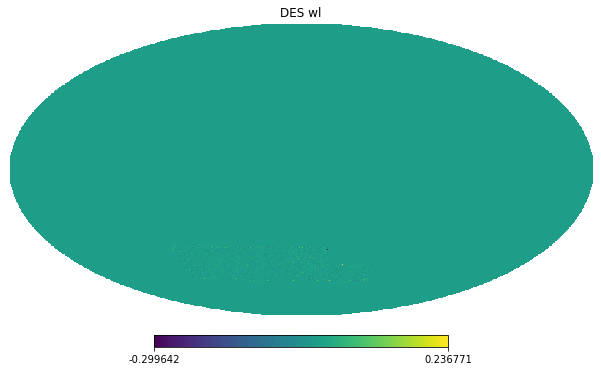

In [17]:
hp.visufunc.mollview(DES_signal_1[1], title= 'DES wl')

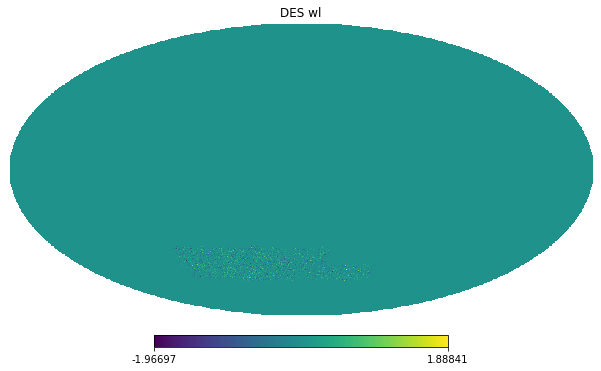

In [18]:
hp.visufunc.mollview(david_signal[1], title= 'DES wl')

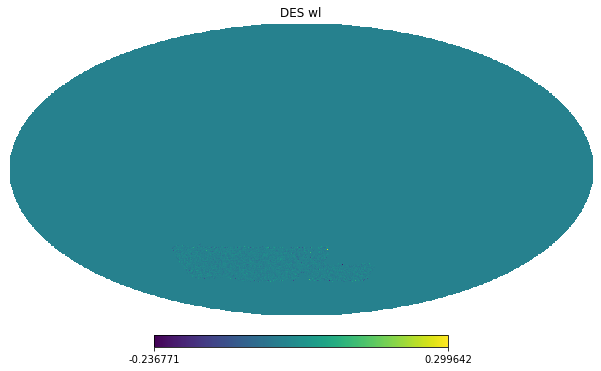

In [19]:
hp.visufunc.mollview(DES_signal_1[0], title= 'DES wl')

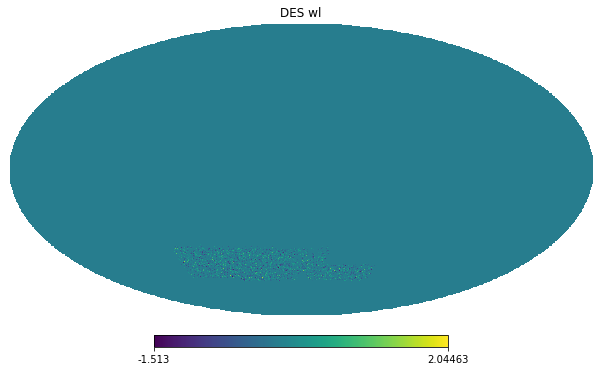

In [20]:
hp.visufunc.mollview(david_signal[0], title= 'DES wl')

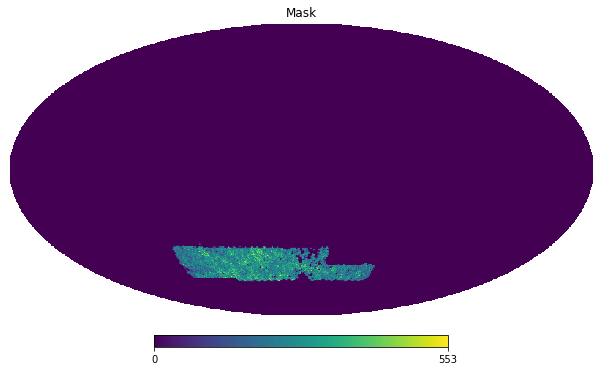

In [21]:
hp.visufunc.mollview(DES_mask_1, title= 'Mask')


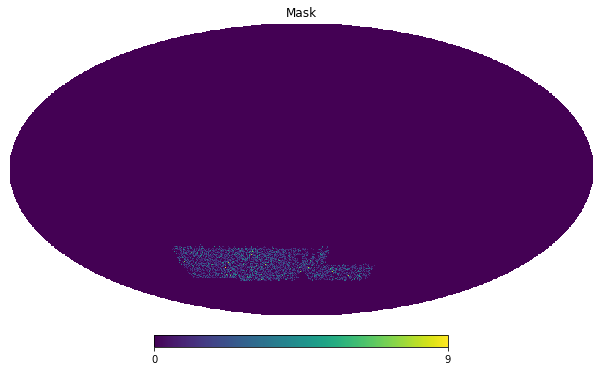

In [22]:
hp.visufunc.mollview(david_mask, title= 'Mask')


In [23]:
DES_f_1 =  DES_1_maps.get_nmt_field()
DES_f_2 =  DES_2_maps.get_nmt_field()

In [24]:
DES_w_11 = nmt.NmtWorkspace()
DES_w_11.compute_coupling_matrix(DES_f_1, DES_f_1, bands)

DES_w_12 = nmt.NmtWorkspace()
DES_w_12.compute_coupling_matrix(DES_f_1, DES_f_2, bands)

In [25]:
def compute_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [26]:
nl_11 = DES_w_11.decouple_cell(DES_1_maps.get_nl_coupled())
cl_11 = compute_cl(DES_f_1, DES_f_1, DES_w_11)
cl_11 = cl_11 - nl_11

In [27]:
cl_12 = compute_cl(DES_f_1, DES_f_2, DES_w_12)

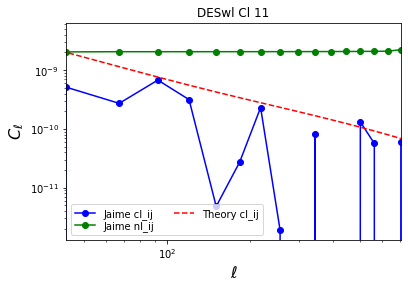

In [28]:
plt.plot(ell_arr, cl_11[0], 'bo-', label='Jaime cl_ij')
plt.plot(ell_arr, nl_11[0], 'go-', label='Jaime nl_ij')
plt.plot(ell_arr, Theory_cl_s1s1, 'r--', label='Theory cl_ij')

plt.loglog()
plt.title('DESwl Cl 11')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

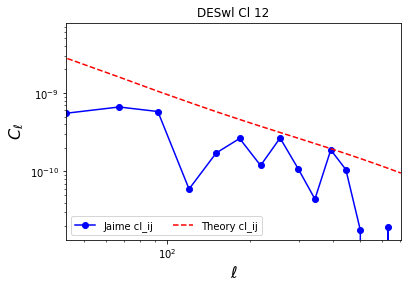

In [29]:
plt.plot(ell_arr, cl_12[0], 'bo-', label='Jaime cl_ij')
plt.plot(ell_arr, Theory_cl_s1s2, 'r--', label='Theory cl_ij')

plt.loglog()
plt.title('DESwl Cl 12')
plt.xlim((ell_arr[1], ell_arr[-1]))
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()